# document-clustering

Following along with Brandon Rose's document clustering tutorial on IMDB movie synopses.

https://github.com/brandomr/document_cluster/blob/master/cluster_analysis.ipynb

http://brandonrose.org/clustering

http://brandonrose.org/top100

In [1]:
%matplotlib inline

import bs4 as BeautifulSoup
import codecs
from collections import Counter
import matplotlib.pyplot as plt
import mpld3
import nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


## Getting the IMDB movie synopsis data

In [2]:
# Get top 100 movie data from IMDB
r = requests.get('http://www.imdb.com/list/ls055592025/')
soup = BeautifulSoup.BeautifulSoup(r.text, 'html.parser')
list_items = soup.findAll('div', attrs={'class': 'list_item'})

URL_BASE = 'http://www.imdb.com'
SYNOPSIS_URL = URL_BASE + '{}' + 'synopsis'   # use with .format(url) for each movie

data = []
for item in list_items:
    number = item.find('div', attrs={'class': 'number'}).text
    info = item.find('div', attrs={'class': 'info'})
    title = info.find('b').text.split('\n')[0]
    year = info.find('span', attrs={'class': 'year_type'}).text
    description = item.find('div', attrs={'class': 'item_description'}).text
    description, length = description.split('. (')[0] + '.', description.split('. (')[1][:-2]
    partial_url = info.find('b').find('a')['href']
    full_url = URL_BASE + info.find('b').find('a')['href']
    synopsis_html = requests.get(SYNOPSIS_URL.format(partial_url)).text
    synopsis_soup = BeautifulSoup.BeautifulSoup(synopsis_html, 'html.parser')
    synopsis = synopsis_soup.find('div', attrs={'id': 'swiki_body'}).text.strip()
    data.append([number, title, year, description, length, partial_url, full_url, synopsis])

In [3]:
titles = [movie[1] for movie in data]
synopses = [movie[7] for movie in data]

## Stopwords, stemming, and tokenizing
Stop words: common words that don't add to the meaning of the text

Stemming: shortening a word to it's root, so that words like "programming", "programmed", and "programs" are all the same.

Tokenizing: {{ fill info in here }}

In [4]:
# For this tutorial we'll use NLTK's stopwords, but sklearn also has a list of stopwords.
# (sklearn's list is actually longer, but includes some strange word choices like 'cry')
stopwords = nltk.corpus.stopwords.words('english')
stopwords_sklearn = feature_extraction.text.ENGLISH_STOP_WORDS

len(stopwords), len(stopwords_sklearn)

(153, 318)

In [5]:
# Load nltk's SnowballStemmer
stemmer = SnowballStemmer('english')

In [6]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_and_stem(text):
    return [stemmer.stem(t) for t in tokenize(text)]

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## TF-IDF and Document Similarity

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                  min_df=0.2, stop_words='english',
                                  use_idf=True, tokenizer=tokenize_and_stem,
                                  ngram_range=(1,3))

In [10]:
tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

In [11]:
tfidf_matrix.shape

(100, 401)

/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/home/steven/anaconda3/envs/pressbot-env/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


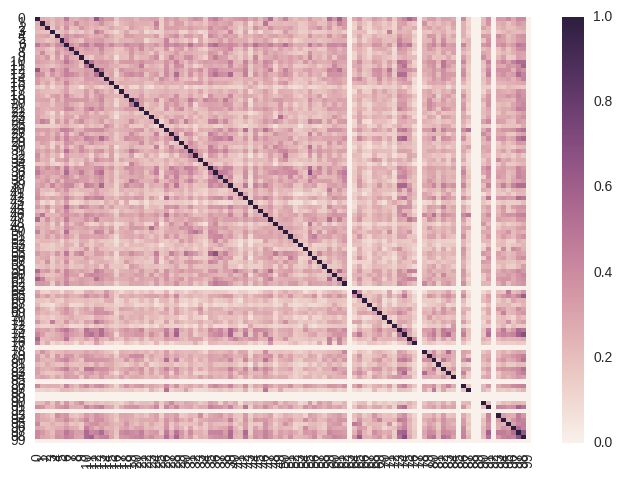

In [12]:
sns.heatmap((tfidf_matrix * tfidf_matrix.T).A)

In [13]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering

In [15]:
NUM_CLUSTERS = 5

km = KMeans(n_clusters=NUM_CLUSTERS)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [16]:
df = pd.DataFrame(data,
                     index=[clusters],
                     columns=['id',
                              'title',
                              'year',
                              'desc',
                              'length',
                              'partial_url',
                              'full_url',
                              'synopses'
                             ]
                    )
df['cluster'] = clusters

df

,id,title,year,desc,length,partial_url,full_url,synopses,cluster
0,1.,The Godfather,(1972),The aging patriarch of an organized crime dyna...,175 mins,/title/tt0068646/,http://www.imdb.com/title/tt0068646/,"In late summer 1945, guests are gathered for t...",0
1,2.,The Shawshank Redemption,(1994),Two imprisoned men bond over a number of years...,142 mins,/title/tt0111161/,http://www.imdb.com/title/tt0111161/,"In 1947, Andy Dufresne (Tim Robbins), a banker...",1
4,3.,Schindler's List,(1993),"In German-occupied Poland during World War II,...",195 mins,/title/tt0108052/,http://www.imdb.com/title/tt0108052/,The relocation of Polish Jews from surrounding...,4
1,4.,Raging Bull,(1980),An emotionally self-destructive boxer's journe...,129 mins,/title/tt0081398/,http://www.imdb.com/title/tt0081398/,"The film opens in 1964, where an older and fat...",1
1,5.,Casablanca,(1942),"In Casablanca, Morocco in December 1941, a cyn...",102 mins,/title/tt0034583/,http://www.imdb.com/title/tt0034583/,"In the early years of World War II, December 1...",1
1,6.,Citizen Kane,(1941),"Following the death of a publishing tycoon, ne...",119 mins,/title/tt0033467/,http://www.imdb.com/title/tt0033467/,"It's 1941, and newspaper tycoon Charles Foster...",1
0,7.,Gone with the Wind,(1939),A manipulative Southern belle carries on a tur...,238 mins,/title/tt0031381/,http://www.imdb.com/title/tt0031381/,"The film opens in Tara, a cotton plantation ow...",0
1,8.,The Wizard of Oz,(1939),Dorothy Gale is swept away to a magical land i...,102 mins,/title/tt0032138/,http://www.imdb.com/title/tt0032138/,Dorothy Gale (Judy Garland) is an orphaned tee...,1
3,9.,One Flew Over the Cuckoo's Nest,(1975),A criminal pleads insanity after getting into ...,133 mins,/title/tt0073486/,http://www.imdb.com/title/tt0073486/,"In 1963 Oregon, Randle Patrick McMurphy (Nicho...",3
2,10.,Lawrence of Arabia,(1962),"The story of T.E. Lawrence, the English office...",216 mins,/title/tt0056172/,http://www.imdb.com/title/tt0056172/,"In 1935, T. E. Lawrence (Peter O'Toole) is kil...",2


In [17]:
df['cluster'].value_counts()

1    34
0    29
3    19
4    14
2     4
Name: cluster, dtype: int64

In [18]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

"""for i in range(len(clusters)):
    print "Cluster {} words".format(i)
    
    for ind in order_centroids[i, :6]:
        part1 = vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0]
        part2 = part1.encode('utf-8', 'ignore')
        print '{}'.format(part2)"""

'for i in range(len(clusters)):\n    print "Cluster {} words".format(i)\n    \n    for ind in order_centroids[i, :6]:\n        part1 = vocab_frame.ix[terms[ind].split(\' \')].values.tolist()[0][0]\n        part2 = part1.encode(\'utf-8\', \'ignore\')\n        print \'{}\'.format(part2)'